In [162]:
import numpy as np
import matplotlib.pyplot as plt
from GRIT_src import *
from tqdm import tqdm
import seaborn as sns

## Convergence test as number of gene gets larger

In [ ]:
n_matrices = 10
n_cells  = [1,10,30,60,100]
n_genes = 5
n_timepoints = 20
dt = 0.1
epsilon = 0.01
b_true = np.zeros(n_genes)

# generate random A matrices
A_true_list = []
# A_true_list.append(np.array([
#     [-0.5,  0.2,    0,    0,    0],
#     [ 0.1, -0.1,  0.3, -0.8,    0],
#     [   0,  0.1, -0.7,  0.2,    0],
#     [   0,  0.8,  0.2, -0.8,  0.1],
#     [   0,    0,    0,  0.1, -0.9]]))

for i in range(n_matrices):
    #A,_ = generate_matrix_with_specific_eigenvalues(n_genes,"negative")
    A = generate_sparse_A(n_genes, sparsity = 0.6)
    A_true_list.append(A)
    # print(A)

A_f_error_list = np.zeros((len(A_true_list), len(n_cells)))-1
A_rel_error_list = np.zeros((len(A_true_list), len(n_cells)))-1
A_pred_list = []

for i in tqdm(range(len(A_true_list))):
    A_pred_temp = []
    for n_cell in n_cells:
        np.random.seed(42)
        b_true = np.zeros(n_genes)
        x0_mean = np.random.random(n_genes)
        scdata,Tgrid = generate_discrete_time_system_data(
            A_true =  A_true_list[i], 
            b_true = b_true, 
            x0 = x0_mean, 
            n_timepoints = n_timepoints, 
            dt= dt, 
            n_cells= n_cell, 
            epsilon= epsilon
        )
        A_pred = GRIT_MATLAB(scdata, Tgrid, epsilon=epsilon)
        A_pred_temp.append(A_pred[:,:-1])
            
        # Calculate error between true and learned A matrices

        A_f_error_list[i, n_cells.index(n_cell)] = np.linalg.norm(A_pred[:,:-1]- A_true_list[i], ord='fro')
        #A_rel_error_list[i, n_cells.index(n_cell)] = np.mean(np.abs(A_pred[:,:-1]- A_true_list[i]) / (np.abs(A_true_list[i]) + 1e-5))
        A_pred_list.append(A_pred_temp)
        #print(f"n_cells: {n_cells}, A_error: {A_error:.4f}")

# plt.figure(figsize=(10, 6))
# plt.plot(np.mean(scdata,2), label=f"matrix: {i}")
# plt.xlabel("Pseudo Time point")
# plt.ylabel("Gene Value")
# plt.legend()
# plt.show()

100%|██████████| 10/10 [04:06<00:00, 24.62s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

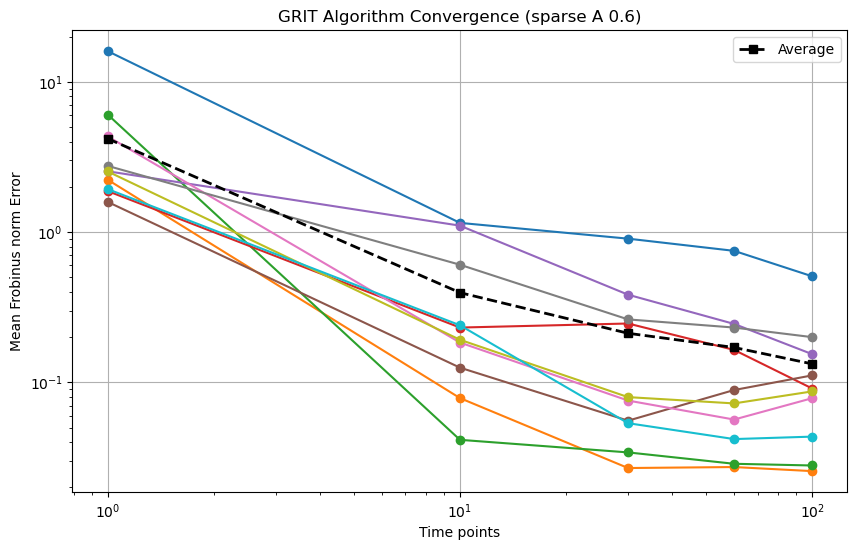

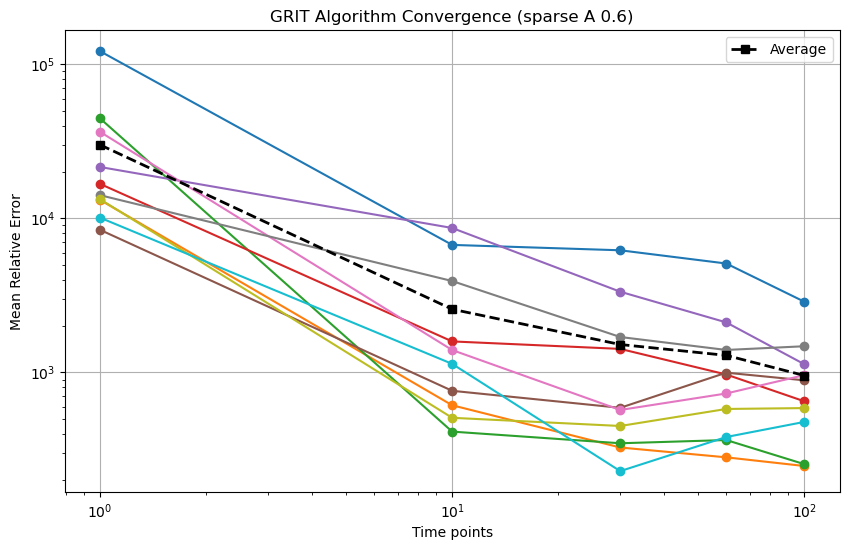

In [ ]:
plt.figure(figsize=(10, 6))
    
# Plot individual lines for each matrix
for i in range(len(A_true_list)):
    plt.plot(n_cells, A_f_error_list[i, :], marker='o')

# Plot average
avg_errors = np.mean(A_f_error_list, axis=0)
plt.plot(n_cells, avg_errors, linestyle='--', linewidth=2, marker='s', 
            color='black', label='Average')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time points')
plt.ylabel('Mean Frobenius norm Error')
#plt.ylabel('Mean Relative Error')
plt.title('GRIT Algorithm Convergence (sparse A 0.6)')
plt.legend()
plt.grid(True)
plt.show
#plt.savefig("Result/ncell_f_A_sparse.png", dpi=300)

plt.figure(figsize=(10, 6))
    
# Plot individual lines for each matrix
for i in range(len(A_true_list)):
    plt.plot(n_cells, A_rel_error_list[i, :], marker='o')

# Plot average
avg_errors = np.mean(A_rel_error_list, axis=0)
plt.plot(n_cells, avg_errors, linestyle='--', linewidth=2, marker='s', 
            color='black', label='Average')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time points')
plt.ylabel('Mean Relative Error')
plt.title('GRIT Algorithm Convergence (sparse A 0.6)')
plt.legend()
plt.grid(True)
plt.show

## Heat map for Frobenius norm as noise level and dimension change


In [ ]:
n_matrices = 30
n_cell  = 50
n_gene_list = [1,2,5,10]
n_timepoint = 30
dt = 0.1
epsilon_list = [0.05, 0.1, 0.5, 1.0, 2.0]
A_f_error = np.zeros((len(n_gene_list), len(epsilon_list),n_matrices))-1 #Frobenius error

# loop over different n_genes
for n_gene in tqdm(n_gene_list):
    A_true_list = []
    b_true = np.zeros(n_gene)

    # generate random A matrices
    for i in range(n_matrices):
        #A,_ = generate_matrix_with_specific_eigenvalues(n_genes,"negative")
        A = generate_sparse_A(n_gene, sparsity = 0.6)
        A_true_list.append(A)
    
    # loop over different epsilon values
    for epsilon in epsilon_list:
        # for every epsilon value, loop over different A matrices
        for i in range(len(A_true_list)):
            x0_mean = np.random.random(n_gene)
            scdata,Tgrid = generate_discrete_time_system_data(
                A_true =  A_true_list[i], 
                b_true = b_true, 
                x0 = x0_mean, 
                n_timepoints = n_timepoint, 
                dt= dt, 
                n_cells= n_cell, 
                epsilon= epsilon
            )
            A_pred = GRIT_MATLAB(scdata, Tgrid, epsilon=epsilon)
            A_f_error[n_gene_list.index(n_gene), epsilon_list.index(epsilon),i] = np.linalg.norm(A_pred[:,:-1]- A_true_list[i], ord='fro')

100%|██████████| 4/4 [07:02<00:00, 105.50s/it]


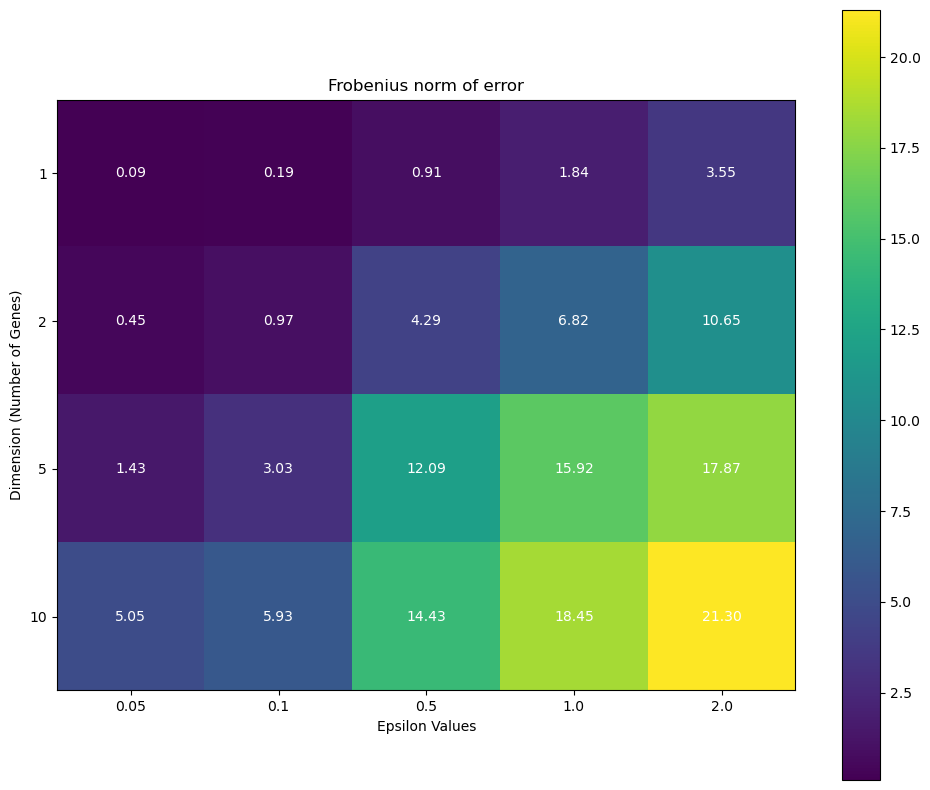

In [173]:
A_f_error_mean = np.mean(A_f_error, axis=2)
plt.figure(figsize=(10, 8))

# Create heatmap
im = plt.imshow(A_f_error_mean, cmap='viridis')

# Add text annotations in each cell with 2 decimal places
for i in range(len(n_gene_list)):
    for j in range(len(epsilon_list)):
        plt.text(j, i, f'{A_f_error_mean[i, j]:.2f}',
                ha="center", va="center", color="white")

# Add colorbar
plt.colorbar(im)

plt.xticks(range(len(epsilon_list)), epsilon_list)
plt.yticks(range(len(n_gene_list)), n_gene_list)

# Add axis labels
plt.xlabel('Epsilon Values')
plt.ylabel('Dimension (Number of Genes)')

plt.title('Frobenius norm of error')
plt.tight_layout()
plt.show()